# Section 3: True color image data

#### Load libraries

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from matplotlib.patches import Patch

### Load data

In [2]:
# a.
fp = os.path.join('/courses/EDS220/data/hwk4_landsat_data', 'landsat8-2018-01-26-sb-simplified.nc')

landsat = rioxr.open_rasterio(fp)

In [3]:
thomas_perimeter = gpd.read_file('data/thomas_perimeter/thomas_perimeter.shp')

In [4]:
# b. Explore the data & write a brief summary
# Check head
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...

### Summary

The landsat data is not a dataframe, so we don't have to explore the data using the normal methods. This incldues `head()`, `info()`, `columns`, etc. When call the data, it produces all that we need to. There are 4 coordinates consisting of a `band`, `x`, `y`, and `spatial_ref`. There are 5 data variables `red`, `green`, `blue`, `nir08`, and `swir22` that represent band types. There is also an index consisting of `band`, `x`, and `y`.

In [5]:
# Drop the `band` variable of the data
landsat = landsat.drop_vars('band')

# Drop the `band` dimension of the data
landsat = landsat.squeeze()

landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (x: 870, y: 731)
Coordinates:
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float64 5MB ...
    green        (y, x) float64 5MB ...
    blue         (y, x) float64 5MB ...
    nir08        (y, x) float64 5MB ...
    swir22       (y, x) float64 5MB ...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


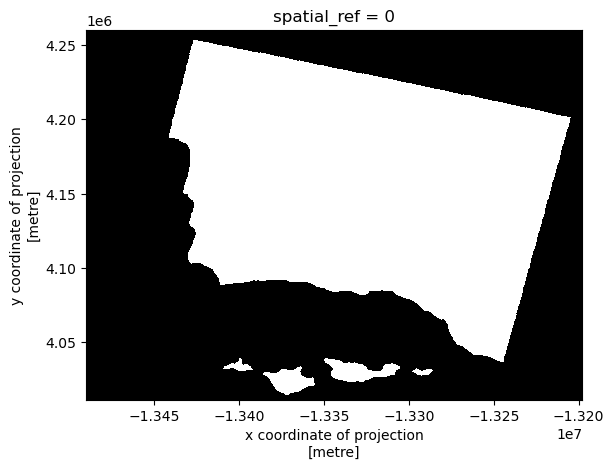

In [19]:
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

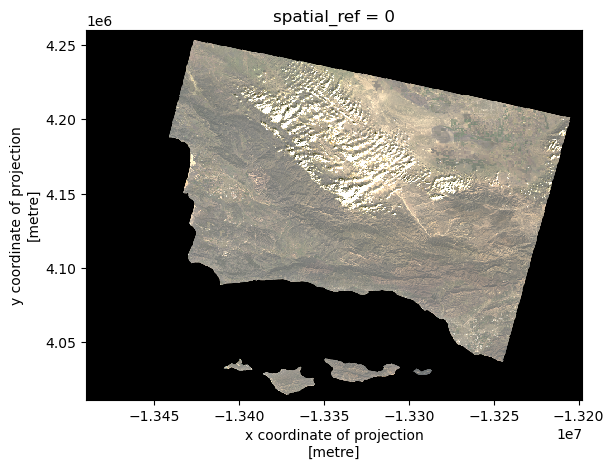

In [20]:
# d. Without creating any new variables....

landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)

## f. Comparing the outputs for parts (a) and (b) CONFUSION??

I don't know what parts a and b is referring to, however I will talk about the output itself. When I first plotted the map, I had a black and white output. When setting the parameter `robust = True`, I got an output with the true colors of the terrain. 

# Section 4: False Color Image

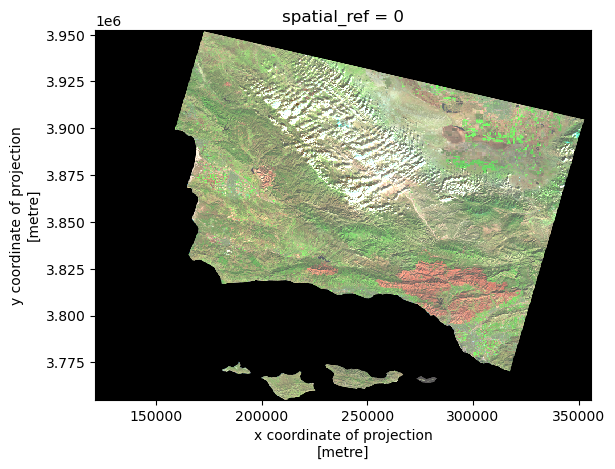

In [7]:
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

# Section 5: Create a map

a. Create a map showing the shortwave infrared/near-infrared/red false color image together with the Thomas Fire perimeter.

b. Write a figure description for the map including a brief explantaion of how false color imagery is being used.

In [8]:
landsat = landsat.rio.reproject("EPSG:3857")

thomas_perimeter = thomas_perimeter.to_crs('EPSG:3857')

In [9]:
landsat.rio.crs == thomas_perimeter.crs



True

/tmp/ipykernel_2210381/4044489563.py:16: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(thomas_perimeter,


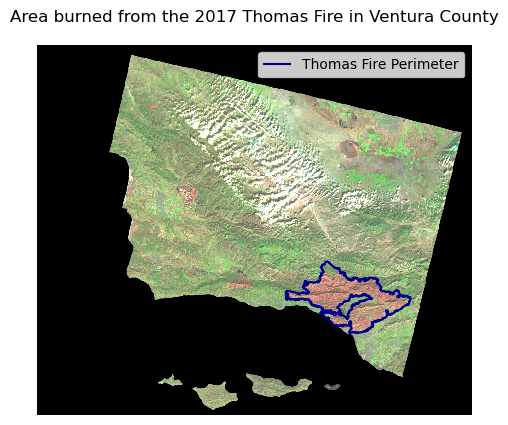

In [15]:
# Create a variable for the false color image map
false_color = landsat[['swir22', 'nir08', 'red']].to_array()

# Set up fig and ax
fig, ax = plt.subplots()

# False color image map
false_color.plot.imshow(robust = True, 
                        ax = ax,
                       alpha = 1)

# Fire perimeters
thomas_perimeter.boundary.plot(ax=ax,
                              color = 'darkblue')
                             
plt.legend(thomas_perimeter,
          labels = ['Thomas Fire Perimeter'])

plt.title("Area burned from the 2017 Thomas Fire in Ventura County")
ax.axis('off')


plt.show()

In [11]:
thomas_perimeter.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
landsat

<xarray.Dataset> Size: 27MB
Dimensions:      (x: 889, y: 757)
Coordinates:
  * x            (x) float64 7kB -1.349e+07 -1.349e+07 ... -1.32e+07 -1.32e+07
  * y            (y) float64 6kB 4.26e+06 4.26e+06 ... 4.012e+06 4.012e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float64 5MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    green        (y, x) float64 5MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    blue         (y, x) float64 5MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    nir08        (y, x) float64 5MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    swir22       (y, x) float64 5MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [13]:
thomas_perimeter.dtypes

YEAR_            int64
STATE           object
AGENCY          object
UNIT_ID         object
FIRE_NAME       object
INC_NUM         object
ALARM_DATE      object
CONT_DATE       object
CAUSE            int64
C_METHOD         int64
OBJECTIVE        int64
GIS_ACRES      float64
COMMENTS        object
COMPLEX_NA      object
IRWINID         object
FIRE_NUM        object
COMPLEX_ID      object
DECADES          int64
geometry      geometry
dtype: object